<a href="https://colab.research.google.com/github/Harshavardhan1005/Forescasting/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the field of Data science/ Machine learning, most of the real life problems are based on prediction of future (Time Series forecasting). In this notebook Time Series Data is forecasted using 
1. Statistical Model
2. Machine Learning Model
3. Deep Learning Model



In [ ]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Reading the data
df = pd.read_csv('/content/drive/MyDrive/Forecast/Stainless-Steel-Prices-Forecasty-Assignment.csv', index_col='Date', parse_dates=True)

In [ ]:
# Shape of dataset with rows and columns
df.shape

(84, 19)

In [ ]:
# Display top 5 records
df.head()

,StainlessSteelPrice,Steel_Inventory_M_USD,Steel_Orders_M_USD,IronOre_Global_USD,CoalAustralia_Global_USD,Energy_Index,Nickel_Global_USD,Zinc_Global_USD,Freight_Transport_Index,WTI_Crude_Global_USD,Baltic_Dry_Index,BCI_China,BCI_Europe,BCI_US,CLI_China,CLI_Europe,CLI_US,PMI_US_Manufacturing,Copper_Global_USD
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,0.827352,20575,10568,127.191304,82.222360,227.022942,13750.31522,1837.619565,-0.4,104.545217,1062,98.80018,99.64265,100.1044,101.1423,99.43615,100.6230,50.9,6906.64
2013-08-01,0.760221,20609,10821,137.055000,82.221429,232.234194,14308.26190,1896.392857,0.5,106.546364,1132,99.04874,99.91766,100.3962,101.1938,99.64082,100.6545,55.4,7186.25
2013-09-01,0.784715,20761,10774,134.185714,83.295918,234.335594,13801.39286,1846.880952,0.1,106.313809,2003,99.27196,100.18490,100.5363,101.2066,99.84383,100.6646,55.7,7159.27
2013-10-01,0.769293,20735,11291,132.572727,85.443634,229.393932,14117.65217,1884.836957,-0.1,100.500435,1504,99.40488,100.36330,100.5771,101.1835,100.02300,100.6666,56.2,7203.02
2013-11-01,0.750242,20854,11559,136.323810,88.363265,225.437049,13684.01190,1866.416667,2.1,93.812381,1821,99.36221,100.49830,100.5459,101.1283,100.17150,100.6744,56.4,7070.65


In [ ]:
# Getting some information of StainlessSteelPrices
df.StainlessSteelPrice.describe()

count    84.000000
mean      0.810715
std       0.143444
min       0.499859
25%       0.743778
50%       0.812157
75%       0.893690
max       1.075014
Name: StainlessSteelPrice, dtype: float64

In [ ]:
# Check if there are any null values
df.isnull().sum()

StainlessSteelPrice         0
Steel_Inventory_M_USD       0
Steel_Orders_M_USD          0
IronOre_Global_USD          0
CoalAustralia_Global_USD    0
Energy_Index                0
Nickel_Global_USD           0
Zinc_Global_USD             0
Freight_Transport_Index     0
WTI_Crude_Global_USD        0
Baltic_Dry_Index            0
BCI_China                   0
BCI_Europe                  0
BCI_US                      0
CLI_China                   0
CLI_Europe                  0
CLI_US                      0
PMI_US_Manufacturing        0
Copper_Global_USD           0
dtype: int64

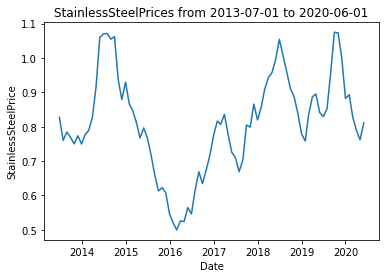

In [ ]:
# Plot StainlessSteelPrices
plt.plot(df['StainlessSteelPrice'])
plt.title('StainlessSteelPrices from 2013-07-01 to 2020-06-01')
plt.xlabel('Date')
plt.ylabel('StainlessSteelPrice')
plt.show()

From the above graph it is observed that from year 2018 to 2020 there exist a seasonal behaviour.

In [ ]:
# Independent and Dependent variables
x = df.iloc[:,1:]
y = df.iloc[:,0:1]

In [ ]:
# Created for comparing the final results
final = pd.DataFrame(df['StainlessSteelPrice'])
output = pd.DataFrame(df['StainlessSteelPrice'].iloc[-12:])

In [ ]:
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(test,predictions): 
    test = np.array(test)
    predictions = np.array(predictions)
    return np.mean(np.abs((test - predictions) / test)) * 100

In [ ]:
# Augmented Dickey-Fuller test
def adf_test(y):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value

    print(dfoutput)
    print("------------------------------")
    pvalue = dftest[1]
    if pvalue < 0.05:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    

In [ ]:
# Train test split
def timeseries_train_test_split(x, y, test_size):
    # get the index after which test set starts
    index = len(x)-int(len(x)*(test_size))
    x_train = x.iloc[:index]
    y_train = y.iloc[:index]
    x_test = x.iloc[index:]
    y_test = y.iloc[index:]
    
    return x_train, x_test, y_train, y_test

# Statistical Model

Time series decomposition allows to decompose out time series into distinct components (Trend,Seasonality and Noise)

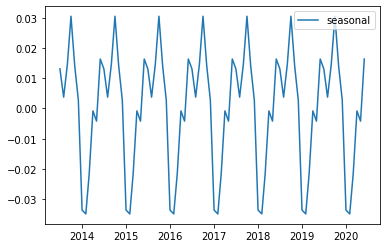

In [ ]:
# Seasonal Decomposotion
decomposition = seasonal_decompose(df['StainlessSteelPrice'])
seasonal = decomposition.seasonal
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')

Augmented Dickey Fuller test is the more accurate assessment test to check if the time series is stationary. 

In [ ]:
# Check if data is stationary
adf_test(df['StainlessSteelPrice'])

Results of Augmented Dickey-Fuller test:
test statistic          -2.346564
p-value                  0.157390
# of lags                1.000000
# of observations       82.000000
Critical Value (1%)     -3.512738
Critical Value (5%)     -2.897490
Critical Value (10%)    -2.585949
dtype: float64
------------------------------
p-value = 0.1574. The series is likely non-stationary.


p-value = 0.157390 > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary (with 95% confidence).

The time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.


In [ ]:
# Differencing (Integrated of order 1 denoted by d)
df['first_difference'] = df['StainlessSteelPrice'] - df['StainlessSteelPrice'].shift(1)

In [ ]:
# Check for stationary
adf_test(df['first_difference'].dropna())

Results of Augmented Dickey-Fuller test:
test statistic         -6.431417e+00
p-value                 1.693719e-08
# of lags               0.000000e+00
# of observations       8.200000e+01
Critical Value (1%)    -3.512738e+00
Critical Value (5%)    -2.897490e+00
Critical Value (10%)   -2.585949e+00
dtype: float64
------------------------------
p-value = 0.0000. The series is likely stationary.


p-value < 0.05: the difference order of 1 of StainlessSteelPrice is stationary (with confidence level of 95%)

ARIMA model can be characterized by 3 terms:
1. p is the order of AR term
2. d is the number of differencing required to make the time series stationary
3. q is the order of MA term

In our case first order differencing makes the data stationary so we can start d value as 1.

p and q values are calculated from  Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.


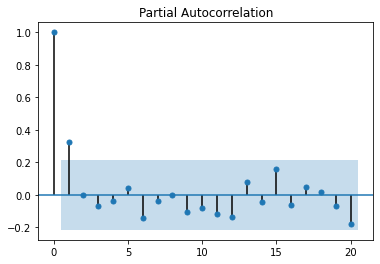

In [ ]:
# Partial Autocorrelation Plot
plot_pacf(df['first_difference'].dropna());

From the above plot lag 1 is above the significant line so we can start p value with 1

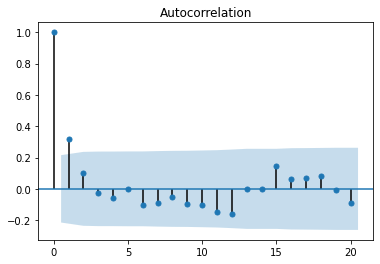

In [ ]:
# Auto correlation plot
plot_acf(df['first_difference'].dropna());

From the above plot there is no exact exponential decrease so we can try with q vaue as o or 1

In [ ]:
# ARIMA model
train = y[0:72]
test = y[72:]

model = ARIMA(train,order=(1,1,1))
model = model.fit()

In [ ]:
# Predictions with ARIMA model
pred = model.predict(start=71,end=84, dynamic=True)

Text(0.5, 1.0, 'Prediction of test data using SARIMAX model')

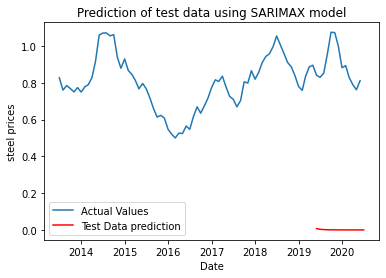

In [ ]:
# Visualizing results of ARIMA model
plt.plot(df['StainlessSteelPrice'],label='Actual Values')
plt.plot(pred,color='red',label='Test Data prediction')
plt.xlabel('Date')
plt.ylabel('steel prices')
plt.legend(loc='best')
plt.title('Prediction of test data using SARIMAX model')

From the above plot it is clear that prediction obtained from ARIMA is not correct.So it can be further checked for seasonality and use SARIMAX.

Tried changing the values of p,q,d using using autoarima by choosing the value having least AIC but there is no significant difference in the output.

In [ ]:
# SARIMAX model
model = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                StainlessSteelPrice   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  84.893
Date:                            Wed, 17 Feb 2021   AIC                           -159.785
Time:                                    08:36:30   BIC                           -149.398
Sample:                                07-01-2013   HQIC                          -155.730
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5370      0.399      1.347      0.178      -0.244       1.318
ma.L1         -0.2599      0.444     -0.585      0.558      -1.131       0.611
ar.S.L12      -0.1322      0.237     -0.558      0.577      -0.597       0.332
ma.S.L12      -0.7089      0.366     -1.935      0.053      -1.427       0.009
sigma2         0.0028      0.001      3.679      0.000       0.001       0.004
===================================================================================
Ljung-Box (Q):                       48.41   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.17   Prob(JB):                         0.42
Heteroskedasticity (H):               0.87   Skew:                             0.24
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model is best if the AIC value is low. Grid search can be applied by varying the values of p,q and d for more accurate predictions or use autoarima

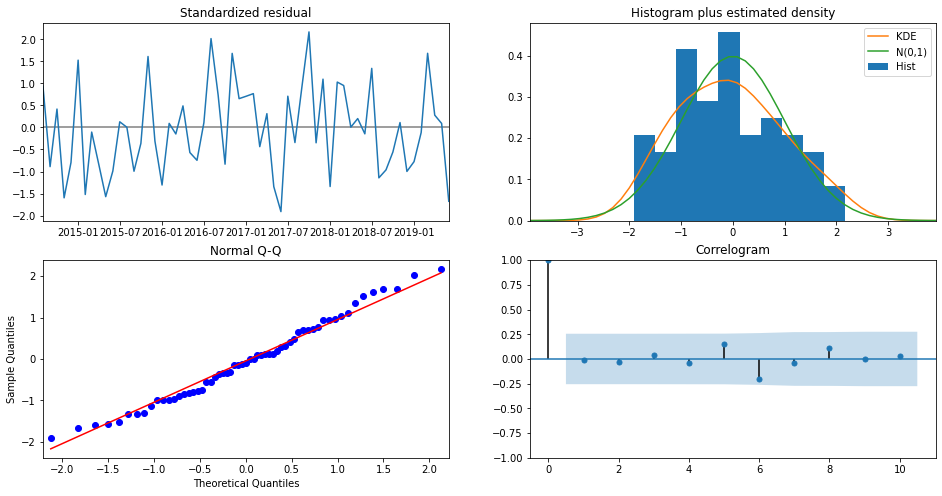

In [ ]:
# Diagnostics to check if there is any unusual behaviour
model_fit.plot_diagnostics(figsize = (16, 8));

It is not exactly perfect, however our model residuals are normally distributed.

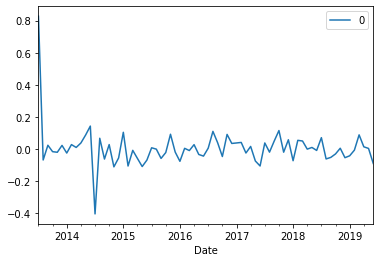

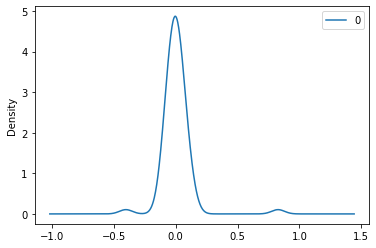

               0
count  72.000000
mean    0.005905
std     0.123444
min    -0.402790
25%    -0.046940
50%     0.000340
75%     0.038777
max     0.827352


In [ ]:
# Plot Residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

If the residual’s mean is non-zero suggesting that there is bias with the model predictionbut here the residual error describes that there is no bias in the prediction because of the zero mean in the residuals.

In [ ]:
# Predictions with SARIMAX model
pred = model_fit.predict(start=71,end=83,dynamic=True)

Text(0.5, 1.0, 'Prediction of test data using SARIMAX model')

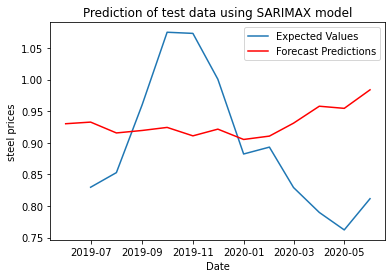

In [ ]:
# Visualizing the results of SARIMAX model
plt.plot(test,label='Expected Values')
plt.plot(pred,color='red',label='Forecast Predictions')
plt.xlabel('Date')
plt.ylabel('steel prices')
plt.legend(loc='best')
plt.title('Prediction of test data using SARIMAX model')

**Observation**

Not so bad! 

SARIMAx model predictions are better when compared with ARIMA model. This model is pretty fast interms of training/fitting time and complexity. 

In [ ]:
# MAPE
print("MAPE using SARIMAX: ",mean_absolute_percentage_error(test,pred))

MAPE using SARIMAX:  11.254014402618171


In [ ]:
final['Statistical_model_predict'] = pd.DataFrame(model_fit.predict(start=1,end=84), index=df.index)
output['Statistical_model_prdiction'] = pd.DataFrame(model_fit.predict(start=72,end=83), index=output.index)

Text(0.5, 1.0, 'Forcasting steel prices for the next 1 year')

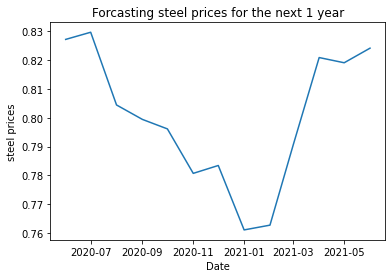

In [ ]:
#Forecast for the next 1 year
forecast = pd.DataFrame(model_fit.predict(start=83,end=95,dynamic=True))
plt.plot(forecast)
plt.xlabel('Date')
plt.ylabel('steel prices')
plt.title('Forcasting steel prices for the next 1 year')

For the following next one year we can see that there is seasonality observed by first decreasing and then increasing in the steel prices.

# Machine Learning Model

In [ ]:
# Train Test Split
x_train, x_test, y_train, y_test = timeseries_train_test_split(x, y, 0.25)

Time series regression problems can be solved using various machine learning regression algorithms. 

In this notebook i will be using Randomforest, XGBoost and Gaussian Process to find better predictions.


In [ ]:
# Check Varience Thresholding
varience_threshold = VarianceThreshold()
varience_threshold.fit(x_train)

VarianceThreshold(threshold=0.0)

In [ ]:
varience_threshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Varience thresholding is applied and found no colmun having varience as 0

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
train_score = rf.score(x_train,y_train)
print ("Training score using Random Forest: ", train_score)

Training score using Random Forest:  0.9777379467176355


In [ ]:
# XGBoost Regressor
xb = XGBRegressor()
xb.fit(x_train,y_train)

[08:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
train_score = xb.score(x_train,y_train)
print ("Training score using XGBoost: ", train_score)

Training score using XGBoost:  0.9994322133513477


In [ ]:
#Gaussian Process Regressor
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
gpr = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
gpr.fit(x_train,y_train)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [ ]:
train_score = gpr.score(x_train,y_train)
print ("Training score using Gaussiona Process:", train_score)

Training score using Gaussiona Process: 0.9078403036492237


In [ ]:
final['Randomforest_predict'] = pd.DataFrame(rf.predict(x), index=df.index)
final['XGboost_predict'] = pd.DataFrame(xb.predict(x), index=df.index)
final['GPR_predict'] = pd.DataFrame(gpr.predict(x), index=df.index)

<function matplotlib.pyplot.show>

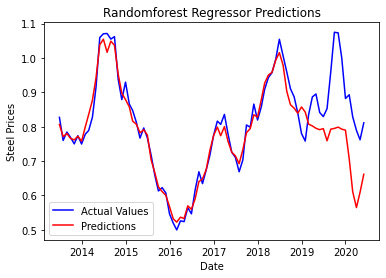

In [ ]:
plt.plot(final.StainlessSteelPrice, color='blue',label='Actual Values')
plt.plot(final.Randomforest_predict, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Steel Prices')
plt.legend(loc='best')
plt.title('Randomforest Regressor Predictions')
plt.show

<function matplotlib.pyplot.show>

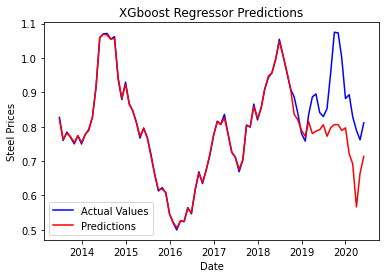

In [ ]:
plt.plot(final.StainlessSteelPrice, color='blue',label='Actual Values')
plt.plot(final.XGboost_predict, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Steel Prices')
plt.title('XGboost Regressor Predictions')
plt.legend(loc='best')
plt.show

XGBoost is perfectly fitting the training data, whereas with the test data it performed significantly simialr following the trend.

<function matplotlib.pyplot.show>

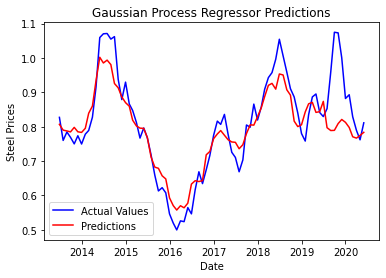

In [ ]:
plt.plot(final.StainlessSteelPrice, color='blue',label='Actual Values')
plt.plot(final.GPR_predict, color='red',label='Predictions')
plt.xlabel('Date')
plt.ylabel('Steel Prices')
plt.title('Gaussian Process Regressor Predictions')
plt.legend(loc='best')
plt.show

**Observation**

Gaussian Processes is the wonderfull technique with a high predicting power. From the plot of Gaussian process, it is follwing the trend of the test data even if it doesnot fit exactly with the train data. The Mean Absolute Percentage Error for the Gaussian process is less when compared with the other machine learning models like Randomforest and XGBoost. 

In [ ]:
print("MAPE using Random Forest: ",mean_absolute_percentage_error(y_test,rf.predict(x_test)))
print("MAPE using XGBoost: ",mean_absolute_percentage_error(y_test,xb.predict(x_test)))
print("MAPE using Gaussian Process: ",mean_absolute_percentage_error(y_test,gpr.predict(x_test)))

MAPE using Random Forest:  13.312375589508907
MAPE using XGBoost:  12.558333959258446
MAPE using Gaussian Process:  8.249845443827628


In [ ]:
output['Machine_Learning_predict'] = pd.DataFrame(gpr.predict(x[-12:]), index=output.index)

# Deep Learning Model

LSTM is used to predict the stainless steel prices, since it performs good if the data is in sequence.

LSTM is sensitive to scaling so scaling of the data is necessary

### Univariate Analysis

In [ ]:
# Data loading and splitting into train and test
train = y.iloc[0:72]
test = y.iloc[72:]

In [ ]:
# Scaling the data 
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[0]

array([0.57301587])

In [ ]:
# Train generator
n_input = 12
n_feature = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input, batch_size=1)


In [ ]:
# Model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_feature)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
__________________________________________________

In [ ]:
# Fit the model
model.fit_generator(train_generator,epochs= 50)

Epoch 1/50
60/60 [==============================] - 4s 12ms/step - loss: 0.2702
Epoch 2/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0710
Epoch 3/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0575
Epoch 4/50
60/60 [==============================] - 1s 12ms/step - loss: 0.0732
Epoch 5/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0608
Epoch 6/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0530
Epoch 7/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0506
Epoch 8/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0494
Epoch 9/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0458
Epoch 10/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0396
Epoch 11/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0406
Epoch 12/50
60/60 [==============================] - 1s 13ms/step - loss: 0.0378
Epoch 13/50
60/60 [==================

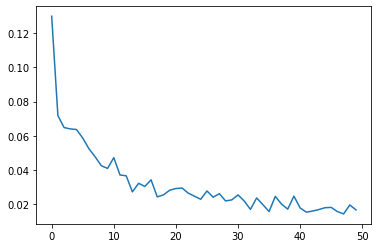

In [ ]:
# Model loss
loss= model.history.history['loss']
plt.plot(loss)

In [ ]:
# Block of code for test predictions
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format of RNN (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_feature))

for i in range(len(test)):
    
    # One timestep ahead 
    current_pred = model.predict(current_batch)[0]
    
    #store that prediction
    test_predictions.append(current_pred)
    
    # update the current batch to include prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

In [ ]:
pred = scaler.inverse_transform(test_predictions)

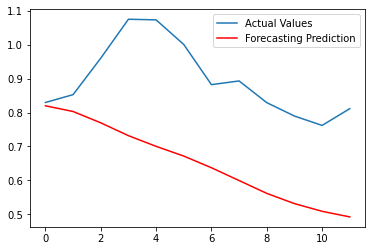

In [ ]:
# Visualization of the results using LSTM
plt.plot(test.values, label='Actual Values')
plt.plot(pred,color='red',label = 'Forecasting Prediction')
plt.legend(loc='best')

In [ ]:
print("MAPE using LSTM: ",mean_absolute_percentage_error(test,pred))

MAPE using LSTM:  27.043711219255567


### Multivariate

In [ ]:
#Train test split of multivariate model
x_train, x_test, y_train, y_test = timeseries_train_test_split(x, y, 0.15)

In [ ]:
# Scaling the train data
scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_train = scaler.transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
# Train generator
n_input = 12
n_feature = 18

train_generator = TimeseriesGenerator(scaled_train,y_train.values,length=n_input, batch_size=1)

In [ ]:
# Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_input, n_feature)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [ ]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 50)            13800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 54,251
Trainable params: 54,251
Non-trainable params: 0
__________________________________________________

In [ ]:
# Fit the model
model.fit_generator(train_generator,epochs= 50)

Epoch 1/50
60/60 [==============================] - 5s 14ms/step - loss: 0.2976
Epoch 2/50
60/60 [==============================] - 1s 14ms/step - loss: 0.1560
Epoch 3/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0967
Epoch 4/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0857
Epoch 5/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0909
Epoch 6/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0900
Epoch 7/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0779
Epoch 8/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0723
Epoch 9/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0925
Epoch 10/50
60/60 [==============================] - 1s 15ms/step - loss: 0.0609
Epoch 11/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0737
Epoch 12/50
60/60 [==============================] - 1s 14ms/step - loss: 0.0589
Epoch 13/50
60/60 [==================

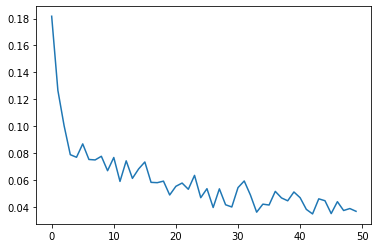

In [ ]:
# Model Loss
loss= model.history.history['loss']
plt.plot(loss)

In [ ]:
# Test data predictions
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format of RNN (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((1,n_input,n_feature))

for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    #store that prediction
    test_predictions.append(current_pred)
    
    # update the current batch to include prediction
    current_batch = np.append(current_batch[:,1:,:],[[scaled_test[i]]], axis= 1)

In [ ]:
pred = test_predictions

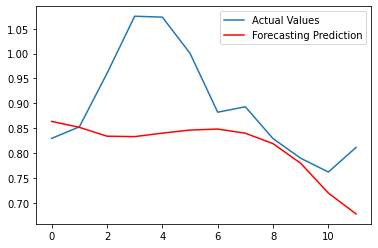

In [ ]:
# Visualization of the results using LSTM
plt.plot(y_test.values, label='Actual Values')
plt.plot(pred,color='red',label = 'Forecasting Prediction')
plt.legend(loc='best')

**Observation:**

LSTM model performed very good it is clearly visible that it accurately follows some of the unexpected jumps/drops. Evaluating univariate mode and multivariate model i found the other features are helping much in finding the predicted value close to actual values.


In [ ]:
# MAPE
print("MAPE using LSTM: ",mean_absolute_percentage_error(pred,y_test))

MAPE using LSTM:  11.052306262367674


In [ ]:
output['Deep_Learning_Prediction'] = pd.DataFrame(pred, index=output.index)

In [ ]:
# comparision of all the predicted results
output

,StainlessSteelPrice,Statistical_model_prdiction,Machine_Learning_predict,Deep_Learning_Prediction
Date,,,,
2019-07-01,0.829620,0.819436,0.873864,0.863751
2019-08-01,0.852754,0.789195,0.797234,0.851824
2019-09-01,0.960255,0.786092,0.789004,0.834014
2019-10-01,1.075014,0.787161,0.789579,0.833168
2019-11-01,1.073200,0.771774,0.809174,0.840143
2019-12-01,1.000625,0.781318,0.821247,0.846343
2020-01-01,0.882237,0.764382,0.812855,0.848389
2020-02-01,0.893123,0.769394,0.797938,0.839980
2020-03-01,0.829167,0.789712,0.770916,0.819049


In the original test data the prices start increasing and then decreased. Among all the model Gaussian processes had given better results by following the trend and giving prediction close to the true values.

**Brief Description:**

SARIMAX which is the varient of ARIMA is used as a statistical model for predicting the steel prices for the given time series data. Time series decomposition is done to check the trend,seasonality and noise and then check whether the data is stationary by Augmented Dickey fuller test based on p value (There are another test ike Rolling mean and Std). If the data is not stationary then do differencing(one can also try by doing the log scale,smooting and averaging). If the data after differencing is stationary then d value is taken as no of lags. q and p values are obtaing by plotiing the Autocorrelation and Partical autocorrelation plots. Based on the parameters p,q,d we can fit the model with test data and make predictions.

Gaussian Process Regressor is used as a machine learning model for predicting the steel prices. I tried using varience thresholding to remove the columns having zero varience. Here the kernal used are the product of constant kernal and RBF for prediction. Althouh it doesnot fit perfectly with the train data. The prediction for the test data are made correctly. From the plots it is very clear that it follows the trends correctly. Among all the other models in machine learning, Gaussial process regressor had given better result.

LSTM are used as Deep learning model because it perform good if the data is in sequence. Here i used univariate and multivariate analysis. I had used the concept of sliding window where prediction are maded based on the past 2 years data. From the output plots we can see that it is following the trend of jumps. I had used Keras tunner to find the number of LSTM layers used for getting the better model. Both the univariate and Bivariate performed good in predicting the trend in the test data.